<a href="https://colab.research.google.com/github/oguchi-ebube/Soccer-Players-Detection-Detectron2/blob/master/Copy_of_Detectron2_Video_Tutorial_masking1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Text(0, 0.5, 'voltage(V)')

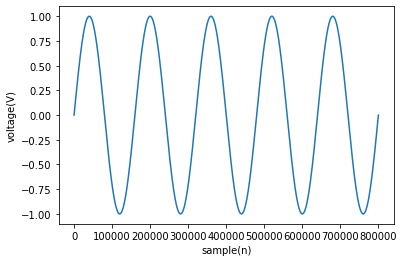

In [0]:
import numpy as np
import matplotlib.pyplot as plt

Fs = 800000
f = 5
sample = 800000
x = np.arange(sample)
y = np.sin(2 * np.pi * f * x / Fs)
plt.plot(x, y)
plt.xlabel('sample(n)')
plt.ylabel('voltage(V)')

In [0]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.4+cu100 in /usr/local/lib/python3.6/dist-packages (1.4.0+cu100)
Requirement already up-to-date: torchvision==0.5+cu100 in /usr/local/lib/python3.6/dist-packages (0.5.0+cu100)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-qh292plh
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-qh292plh
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=275304 sha256=65ec4d77a6a276cd94f6cf8f81de79d0fa2b77fb9f282b9d700429af764ed4e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-w85aqcox/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software F

In [0]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html


In [0]:
# cd "/content/detectron2_repo/detectron2"

In [0]:
import detectron2
import cv2


from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode


In [0]:
# import some common detectron2 utilities
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2

import numpy as np
from IPython.display import clear_output, Image, display, HTML
import base64

In [0]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -q -e detectron2_repo

fatal: destination path 'detectron2_repo' already exists and is not an empty directory.


In [9]:
# create config
cfg = get_cfg()
# below path applies to current installation location of Detectron2
cfgFile = "/content/detectron2_repo/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"
cfg.merge_from_file(cfgFile)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.63  # set threshold for this model
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl"
classes = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
# for i in classes:
# if classes = "person":
#   classes = "player"
#   print(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes)

# metadata_classes = MetadataCatalog.get(thing_classes)
# print(classes)
print(cfg.DATASETS)



PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
PROPOSAL_FILES_TEST: ()
PROPOSAL_FILES_TRAIN: ()
TEST: ('coco_2017_val',)
TRAIN: ('coco_2017_train',)


In [10]:
predictor = DefaultPredictor(cfg)
print("Predictor has been initialized.")
print(predictor)

Predictor has been initialized.


In [0]:
from google.colab.patches import cv2_imshow
import time
import progressbar
from time import sleep
from collections import deque
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import GenericMask
import imutils


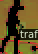

/content/detectron2_repo/detectron2/utils/visualizer.py:245: UserWarning: Attempting to set identical bottom == top == 1 results in singular transformations; automatically expanding.
  ax.set_ylim(self.height)


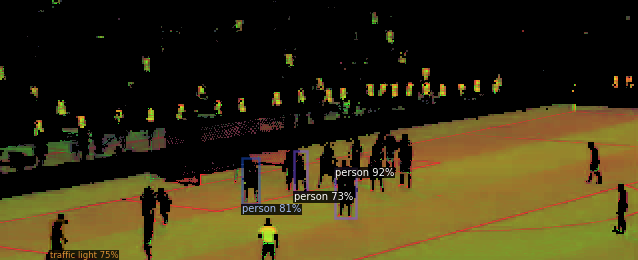

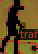

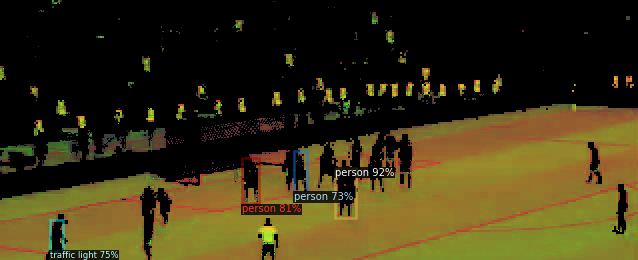

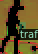

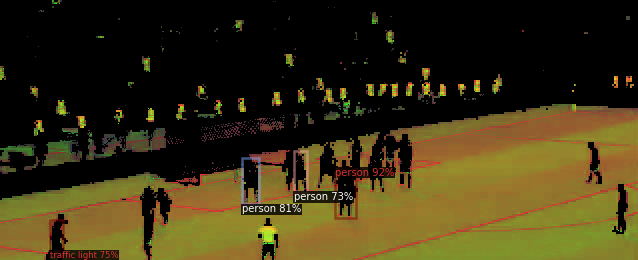

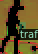

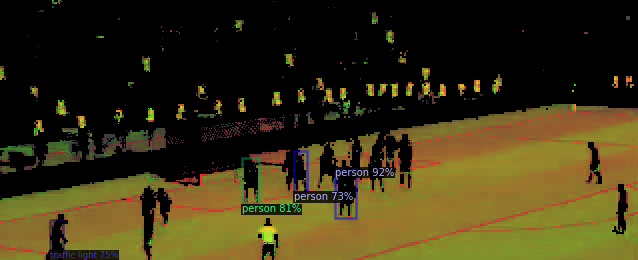

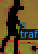

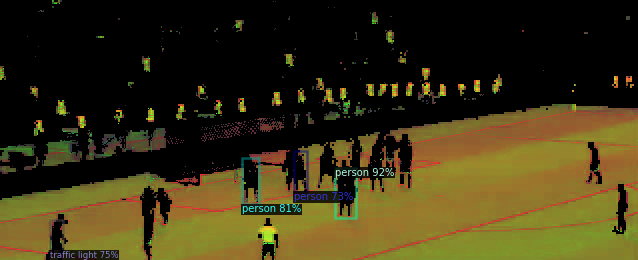

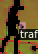

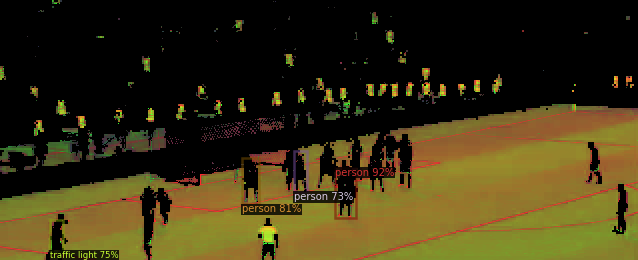

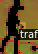

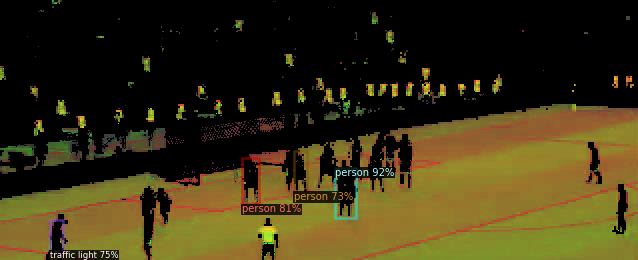

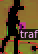

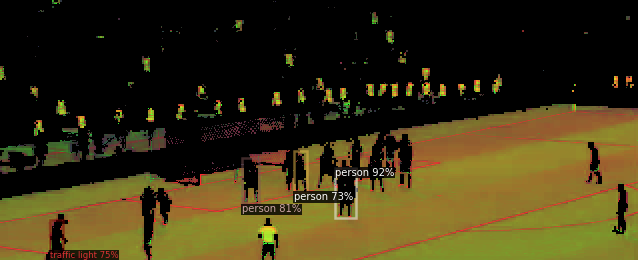

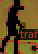

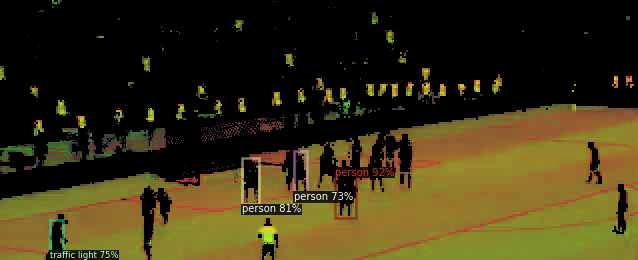

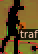

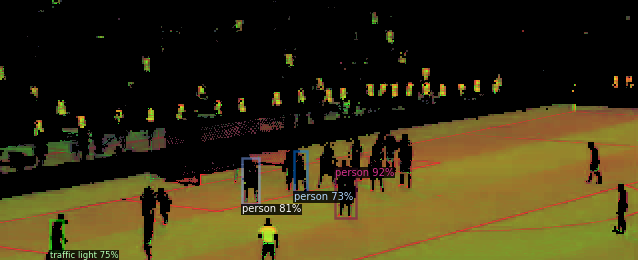

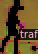

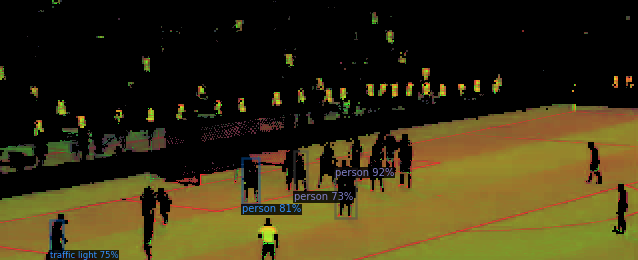

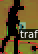

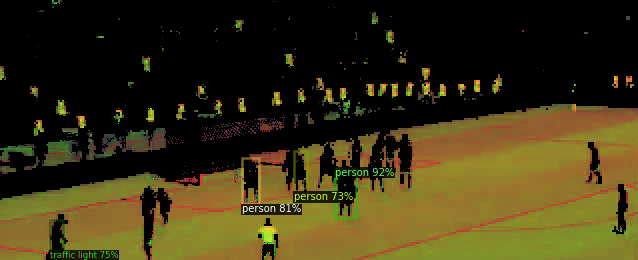

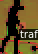

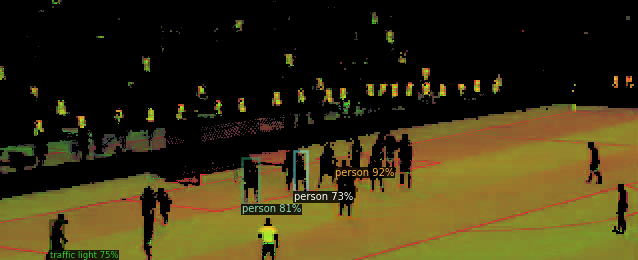

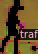

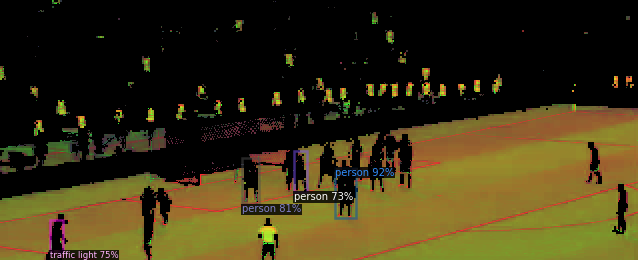

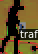

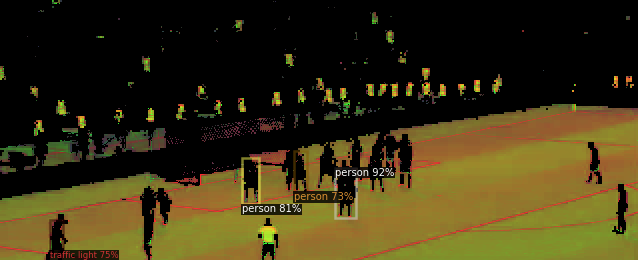

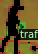

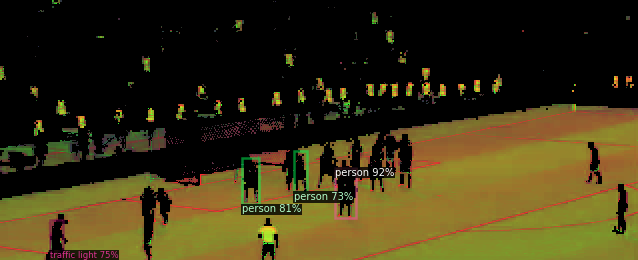

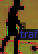

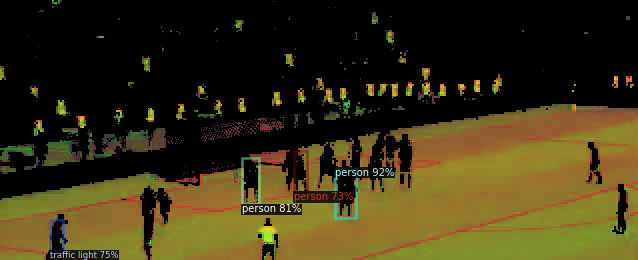

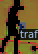

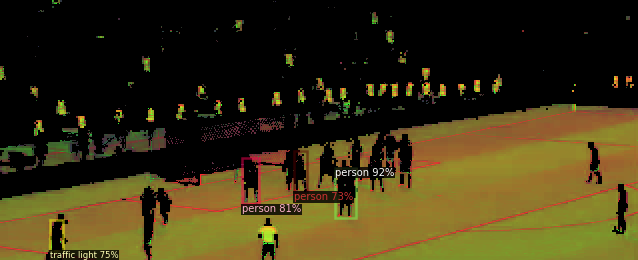

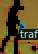

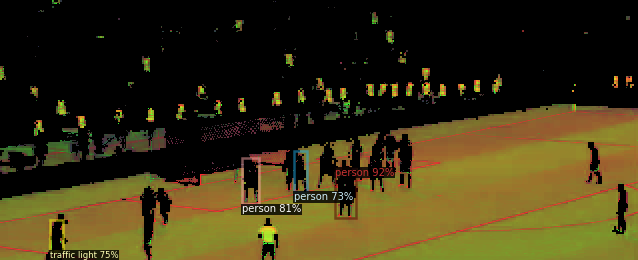

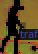

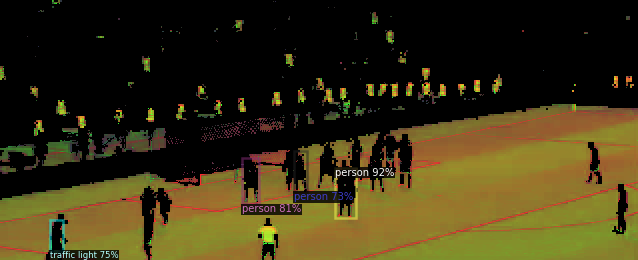

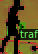

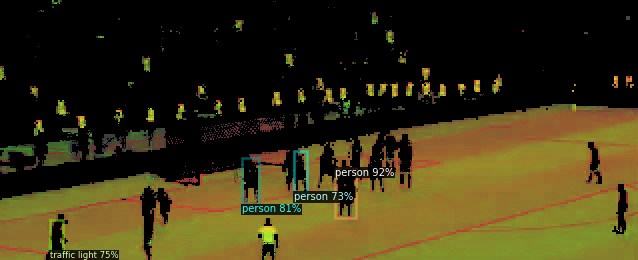

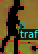

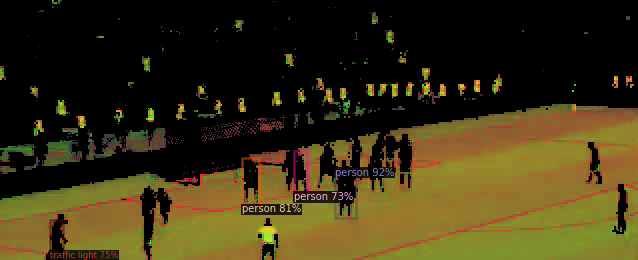

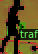

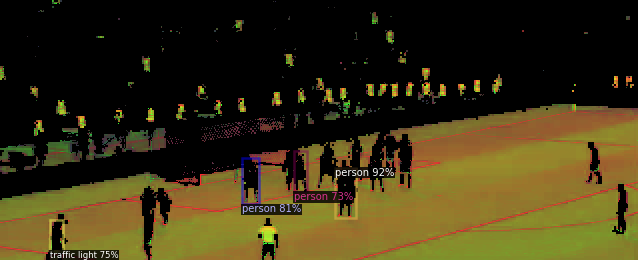

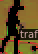

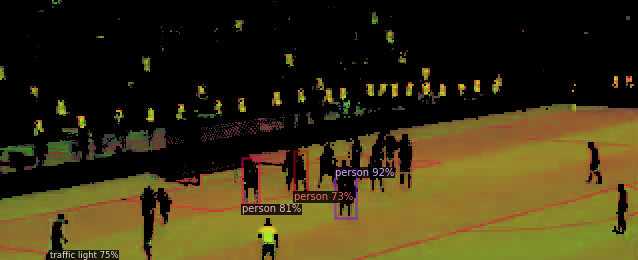

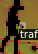

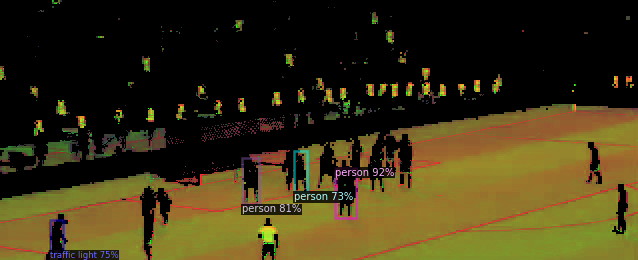

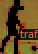

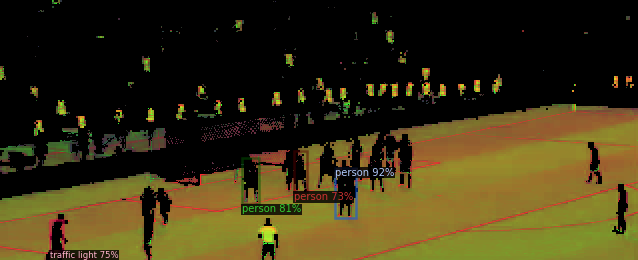

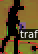

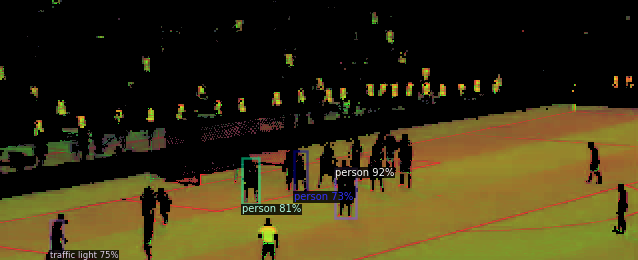

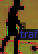

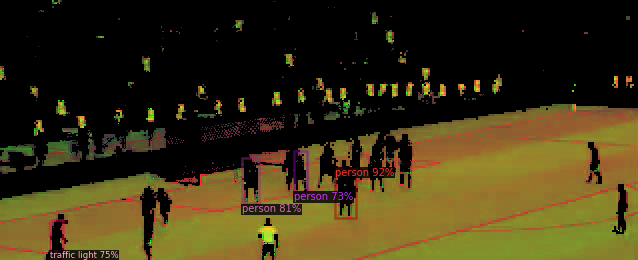

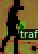

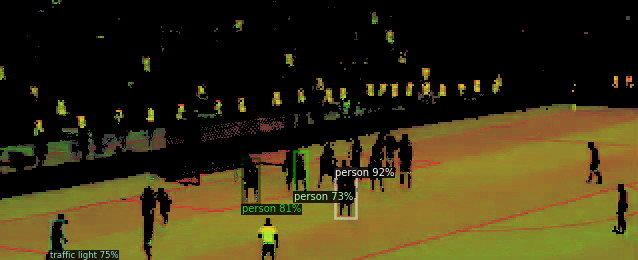

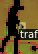

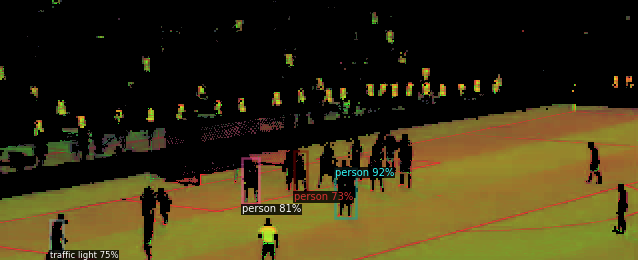

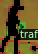

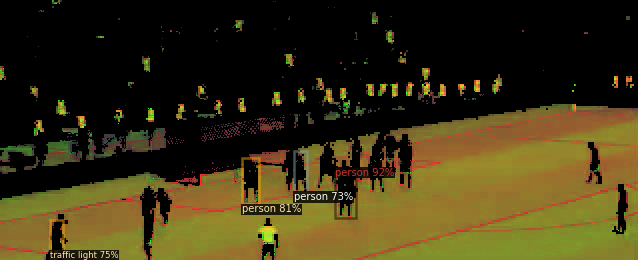

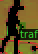

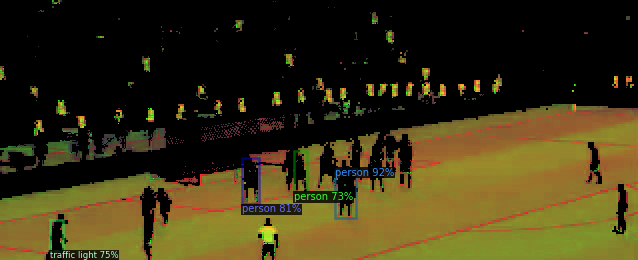

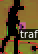

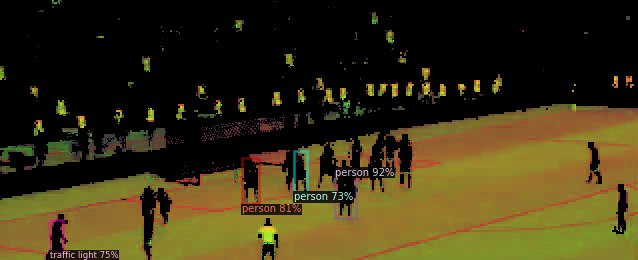

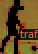

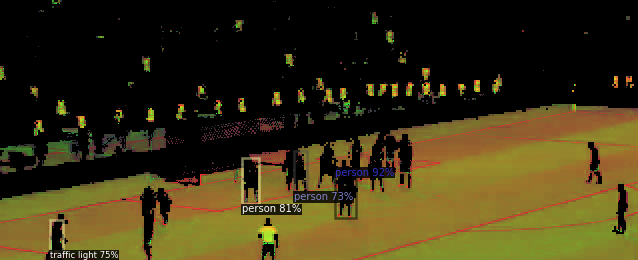

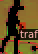

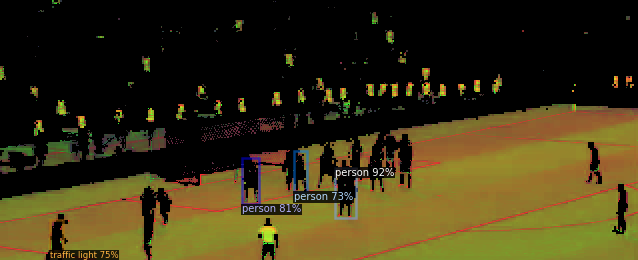

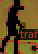

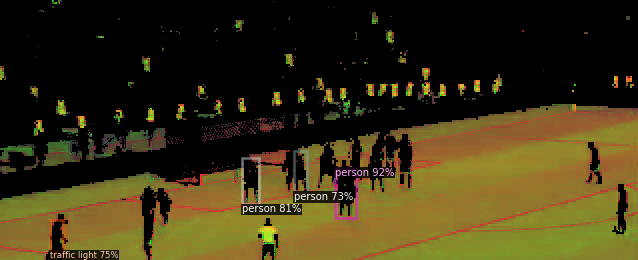

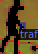

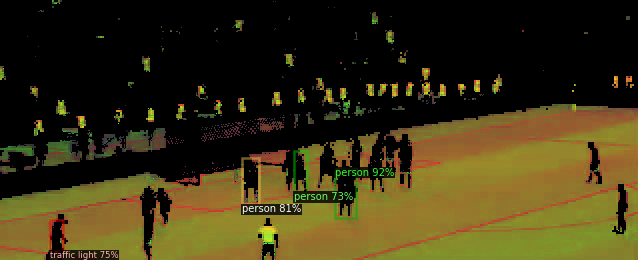

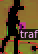

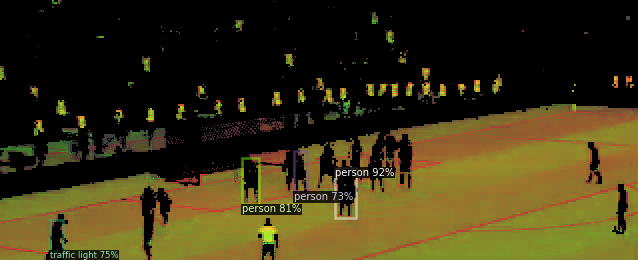

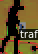

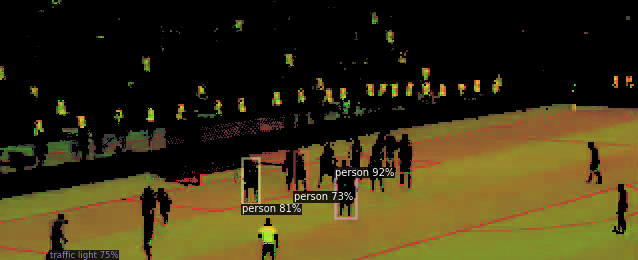

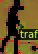

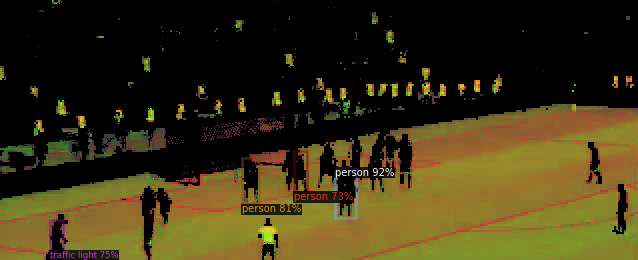

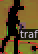

In [0]:
import cv2
vs = cv2.VideoCapture("/content/soccer.mp4")
totalFrames = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))

# grabbed = True
# currentFrame = 0
# start = time.time()
# writer = None

output_fname = "/content/drive/My Drive/Colab Notebooks/manutd_and_chelsea_detected.mp4"
# Configure the video writer
width = int(vs.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vs.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = vs.get(cv2.CAP_PROP_FPS)
num_frames = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))

# some installation of opencv may not support x264 (due to its license),
# you can try other format (e.g. MPEG)
outvideo = cv2.VideoWriter(
                filename=output_fname,
                fourcc=cv2.VideoWriter_fourcc(*"MP4V"),
                fps=float(frames_per_second),
                frameSize=(width, height),
                isColor=True,
            )
grabbed, frame = vs.read()
if grabbed == False:
  break

# loop over frames from the video file stream (207)
while (vs.isOpened()):

  
  hsv = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
  lower_range = np.array([40, 40, 40]) # Set the Lower range value of green in BGR
  upper_range = np.array([70, 255, 255])# Set the Upper range value of green in BGR


  # Create a mask with range
  mask = cv2.inRange(hsv, lower_range, upper_range)     
  result = cv2.bitwise_and(frame, frame, mask = mask)
  res_bgr = cv2.cvtColor(result,cv2.COLOR_HSV2BGR)
  res_gray = cv2.cvtColor(result,cv2.COLOR_BGR2GRAY)
  
  
  #Defining a kernel to do morphological operation in threshold #image to get better output.
  kernel = np.ones((13,13),np.uint8)
  thresh = cv2.threshold(res_gray,127,255,cv2.THRESH_BINARY_INV |  cv2.THRESH_OTSU)[1]
  thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel) 
  #get contours
  contours,hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

  for c in contours:
    x, y, w, h = cv2.boundingRect(c)

    player_img = frame[y:y + h, x:x + w]
    player_hsv = cv2.cvtColor(player_img, cv2.COLOR_BGR2HSV)
    mask1 = cv2.inRange(player_hsv, lower_range, upper_range)
    res1 = cv2.bitwise_and(player_img, player_img, mask=mask1)
    res1_bgr = cv2.cvtColor(res1,cv2.COLOR_HSV2BGR)
    res1_gray = cv2.cvtColor(res1,cv2.COLOR_BGR2GRAY)
    res1_hsv = cv2.cvtColor(res1,cv2.COLOR_BGR2HSV)
    # cv2_imshow(res1_gray)
    outputs = predictor(res1_hsv)  
    v = VideoVisualizer(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
    v = v.draw_instance_predictions(res1_hsv,outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image())
    cv2_imshow(result)
    outvideo.write(v.get_image())
    
    # print(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
    # if cfg.DATASETS.TRAIN[thing_classes[0]] == "person":
    #    cfg.DATASETS.TRAIN[thing_classes[0] == "player"
    # cv2_imshow(frame)
    # cv2_imshow(frame) 
    if cv2.waitKey(1) == 27:
      break  # esc to quit
vs.release()





In [0]:
#to display logs
!log_file = "/content/drive/My Drive/Colab Notebooks/log.log"

!python train.py > "${log_file}"

In [0]:
 # return cv2.inRange(result, lower_range, upper_range)  


#    # Get player positions
#   outputs = predictor(frame)  
#   instances = outputs["instances"].to("cpu")
#   boxes = instances.get("pred_boxes")

#   mask = getPlayersMask(frame)
  
#   # cv2_imshow(mask)

#   # Get the contours from the players "dots" so we can reduce the coordinates
#   # to the number of players on the court.
#   cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#   cnts = imutils.grab_contours(cnts)
#   if cnts is not None:
#     for cnt in cnts:
#       v = Visualizer(frame[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
#       v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#       img = arrayShow(v.get_image()[:, :, ::-1])
#       display(img)
#       outvideo.write(v.get_image()[:, :, ::-1])

#     currentFrame += 1
#     bar.update(currentFrame)
  
#   else:
#     grabbed = False

# cv2_imshow(img)
    
# writer.release()
# vs.release()
# bar.finish()

# end = time.time()
# elap = (end - start)
# print("[INFO] process took {:.4f} seconds".format(elap))

# print("Video created")


# while True:
#     ret, image = cap.read()

#     #define the contours on each frame
#     contours,hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
# # loop through the contours
#     for c in contours:
#         x, y, w, h = cv2.boundingRect(c)
#         print(x,y,w,h)
#         # detect contours that only has height > width
#         if (h >= (1.5) * w):
#             if (w > 15 and h >= 15):
#               outputs = predictor(image)
#               print(outputs)
#               v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
#               v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#               img = arrayShow(v.get_image()[:, :, ::-1])
#               display(img)
#               outvideo.write(v.get_image()[:, :, ::-1])
# if cv2.waitKey(1) == 27:
#   break  # esc to quit
# cap.release()


In [0]:
# predictor = DefaultPredictor(cfg)
# print("Predictor has been initialized.")
# print(predictor)

In [0]:
# # Create config
# cfg = get_cfg()
# cfg.merge_from_file("/content/detectron2_repo/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.89  # set threshold for this model
# cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl"
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 

# MetadataCatalog.get("metadata_classes").set(thing_classes=["person","sports ball"])


In [0]:
# print(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))

In [0]:
# # Create config
# cfg = get_cfg()
# cfg.merge_from_file("/content/detectron2_repo/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.89  # set threshold for this model
# model_path = "detectron2://COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl"
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4 

# MetadataCatalog.get("metadata_classes").set(thing_classes=["player","sports ball"])

# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, model_path)


In [0]:
# # Create predictor
# predictor = DefaultPredictor(cfg)

In [0]:
# def arrayShow (imageArray):
#     ret, png = cv2.imencode('.png', imageArray)
#     encoded = base64.b64encode(png)
#     return Image(data=encoded.decode('ascii'))

In [0]:
# metadata_classes = MetadataCatalog.get("metadata_classes")

In [0]:
# from google.colab.patches import cv2_imshow
# def visualize_predictions(frame, metadata, preds):
#     v = Visualizer(frame[:, :, ::-1],
#                    metadata=metadata,
#                    scale=1,
#                    instance_mode=ColorMode.IMAGE
#                    )
#     v = v.draw_instance_predictions(preds["instances"].to("cpu"))
#     return v.get_image()[:, :, ::-1]

# if __name__ == "__main__":


#     cap = cv2.VideoCapture("/content/drive/My Drive/Colab Notebooks/manutd_and_chelsea.mp4")
    

#     width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#     height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#     frames_per_second = cap.get(cv2.CAP_PROP_FPS)
#     num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     outvideo = cv2.VideoWriter("/content/drive/My Drive/Colab Notebooks/manutd_and_chelsea_det1.mp4",fourcc=cv2.VideoWriter_fourcc(*"MPEG"),fps=float(frames_per_second),frameSize=(width, height),isColor=True,)
#     ret, frame = cap.read()
#     frame_det = 2
#     preds = predictor(frame)
#     del ret, frame

#     while cap.isOpened():
#         ret, frame = cap.read()

#         if (frame_det == 2):
#             preds = predictor(frame)
#             frame_det = 0
#         frame_det += 1
#           # using a greyscale picture, also for faster detection
#         gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

#         # detect people in the image

#         outputs = predictor(frame)
#         outputs = outputs["instances"].pred_boxes.to('cpu').tensor.numpy().astype(int)
#         cv2_imshow(outputs)

#         lower_green = np.array([40, 40, 40])
#         upper_green = np.array([70, 255, 255])
#         # lower_blue = np.array([110, 50, 50])
#         # upper_blue = np.array([130, 255, 255])
#         # lower_red = np.array([0, 31, 255])
#         # upper_red = np.array([176, 255, 255])
#         # lower_white = np.array([0, 0, 0])
#         # upper_white = np.array([0, 0, 255])


#         # Define a mask ranging from lower to uppper
#         mask = cv2.inRange(frame, lower_green, upper_green)
#         # Do masking
#         res = cv2.bitwise_and(frame, frame, mask=mask)
#         res_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#         # Defining a kernel to do morphological operation in threshold image to
#         # get better output.
#         kernel = np.ones((13, 13), np.uint8)
#         thresh = cv2.threshold(res_gray, 127, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
#         thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

#         # define the contours on each frame
#         contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         # cv2.drawContours(image, contours, -1, (0.255, 0), 2)


#         prev = 0
#         font = cv2.FONT_HERSHEY_SIMPLEX

#         for c in contours:
#           image = visualize_predictions(frame, metadata_classes, preds)
#           outvideo.write(image)
#           cv2_imshow(image)
#           if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
# cap.release()
# cv2.destroyAllWindows()


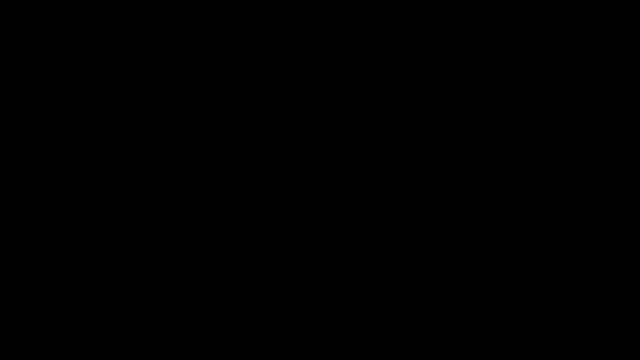

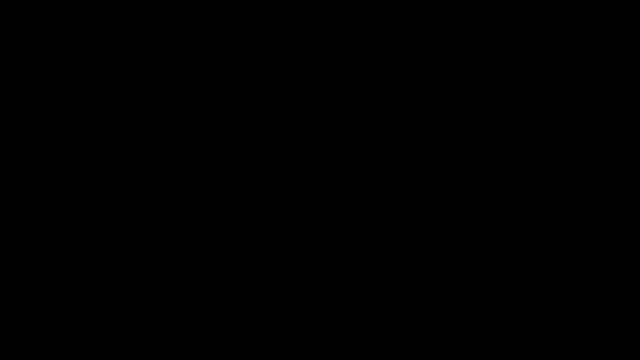

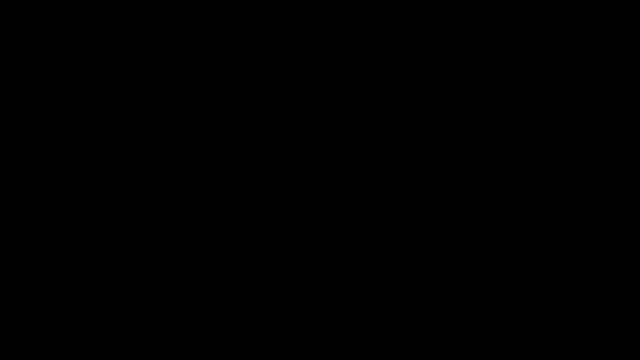

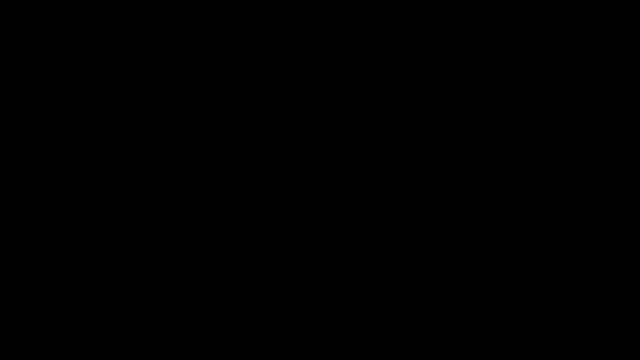

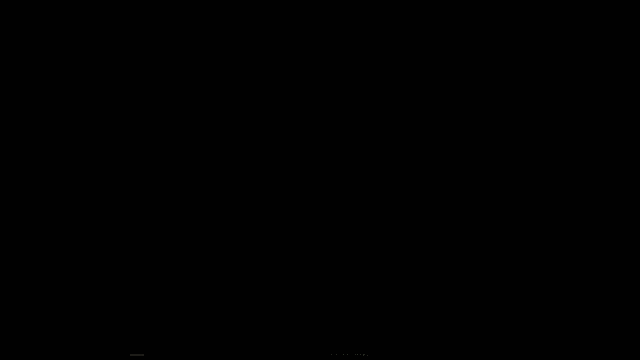

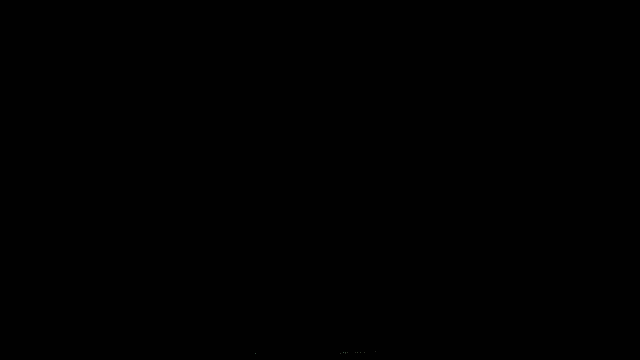

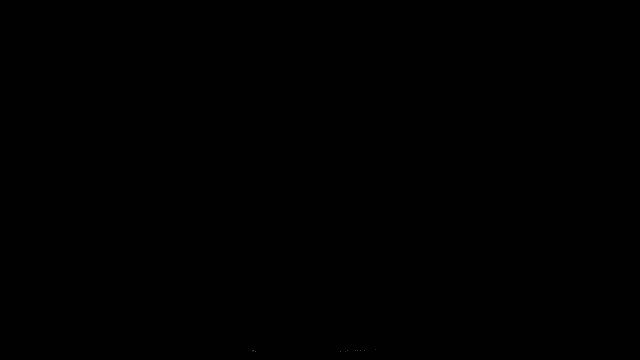

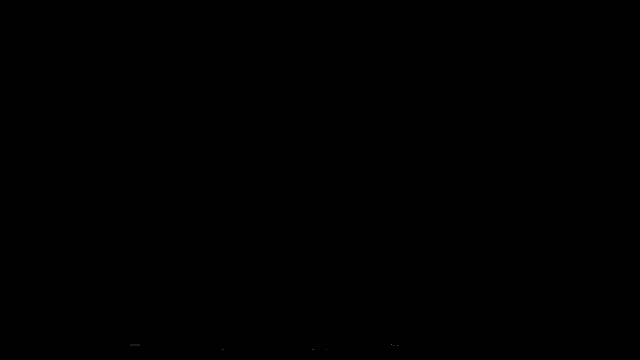

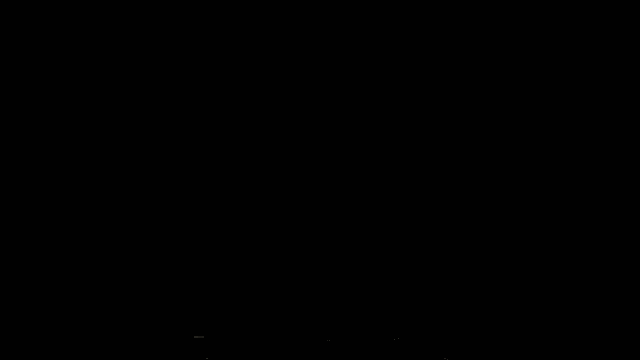

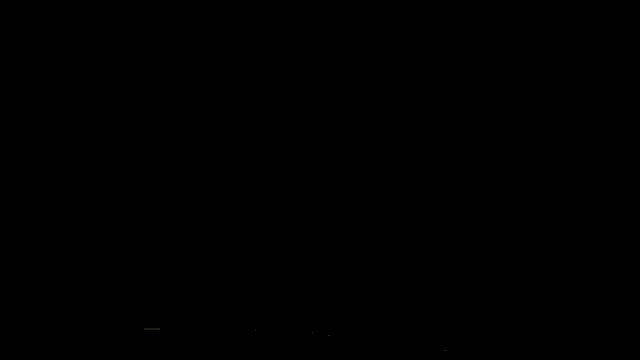

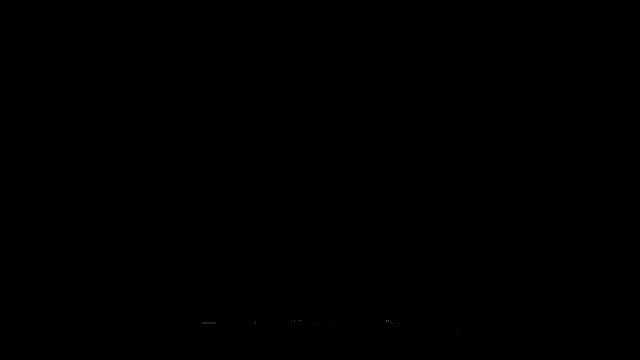

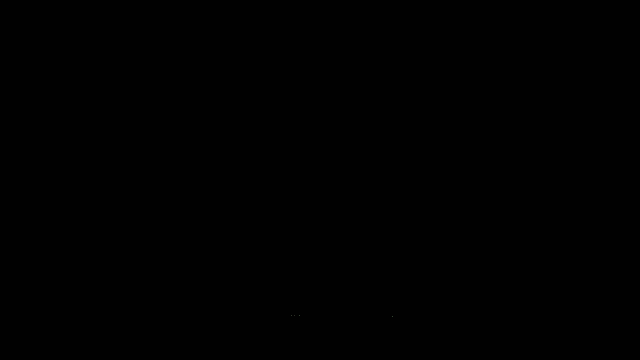

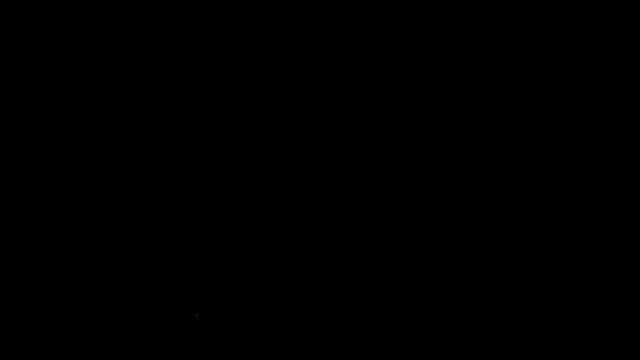

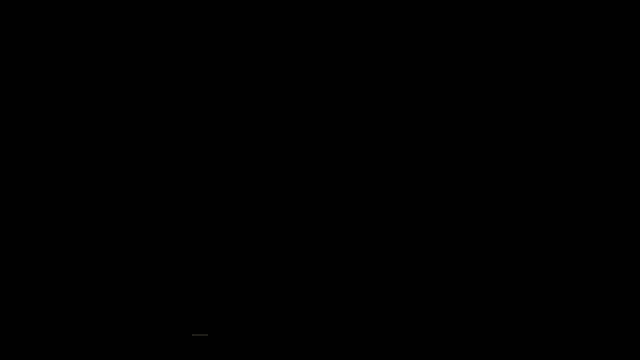

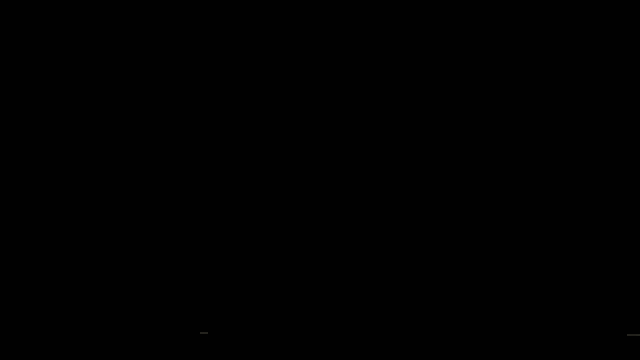

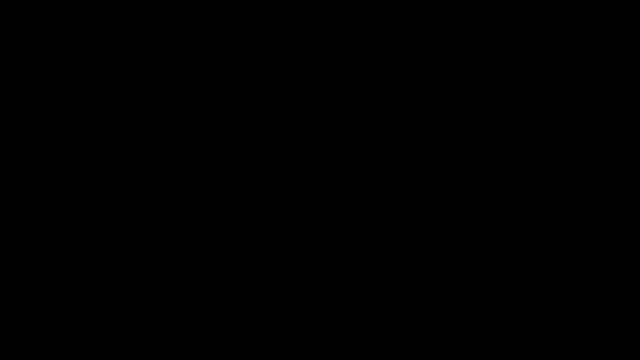

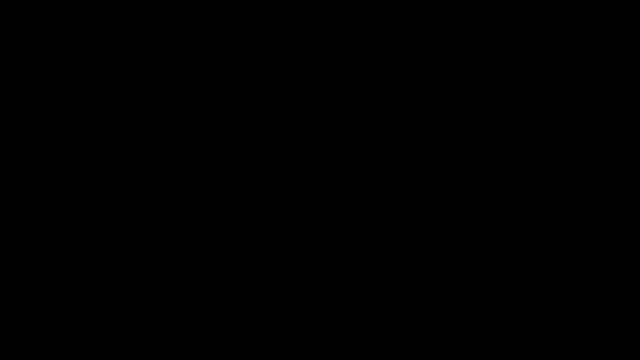

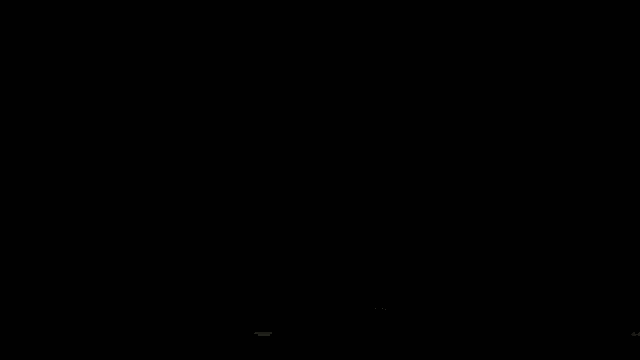

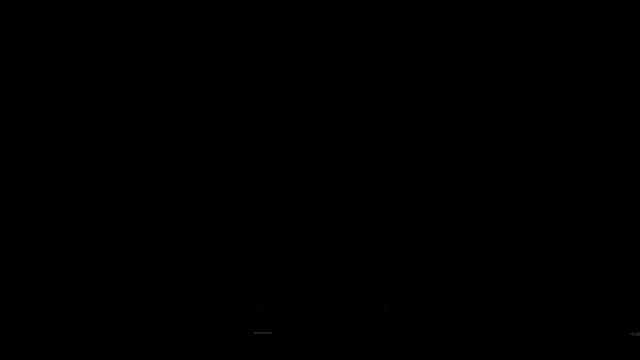

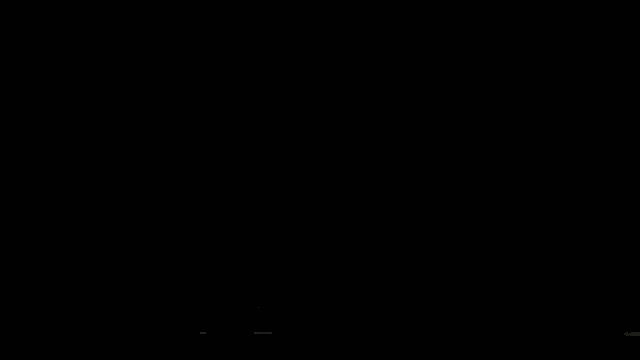

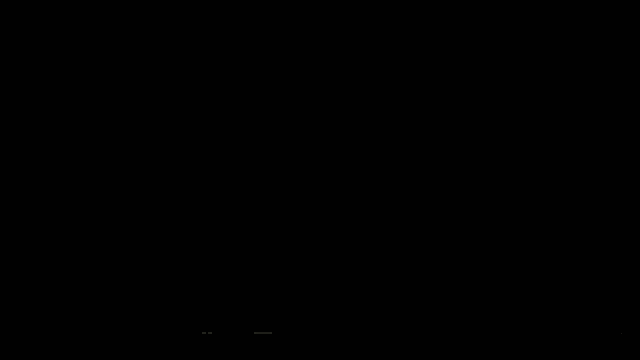

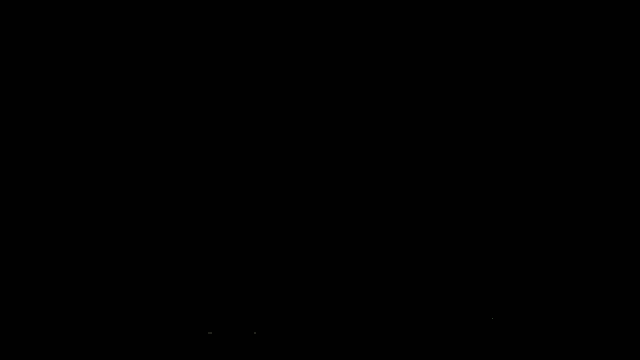

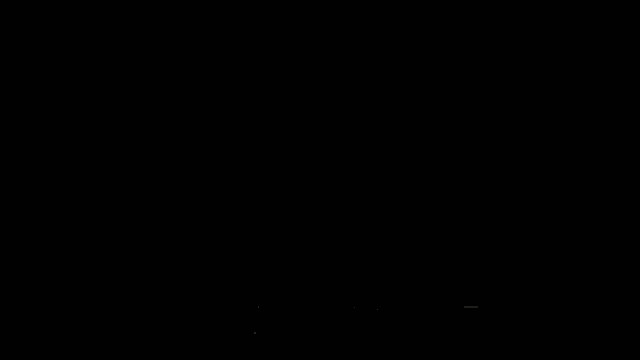

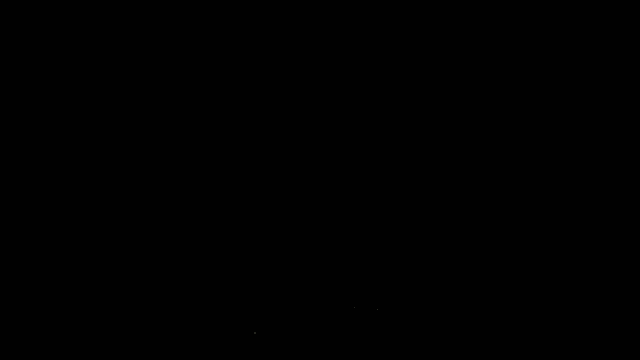

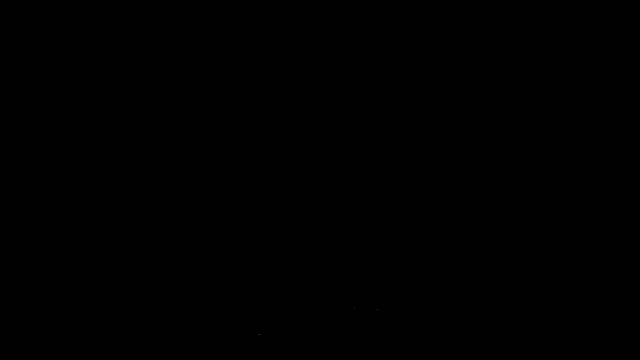

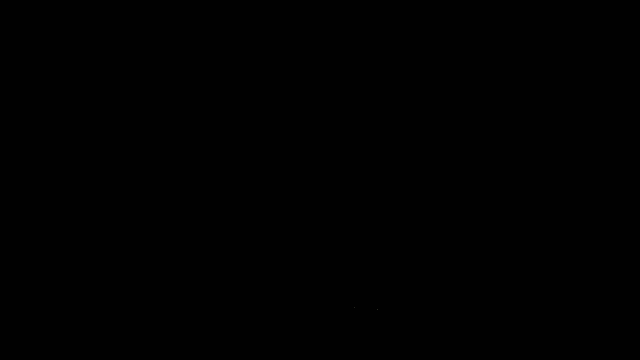

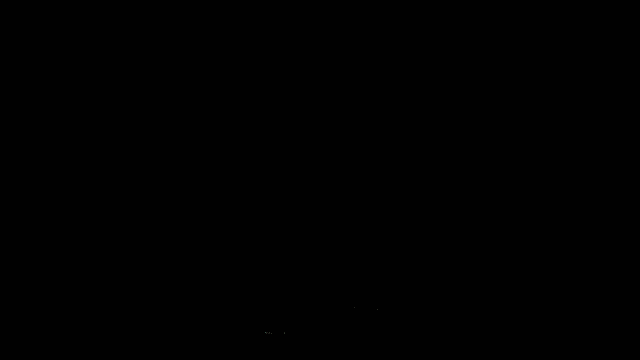

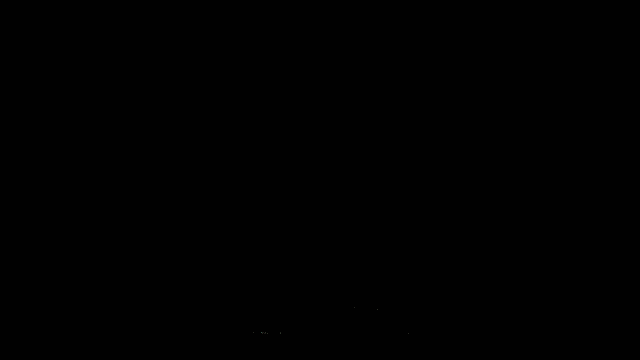

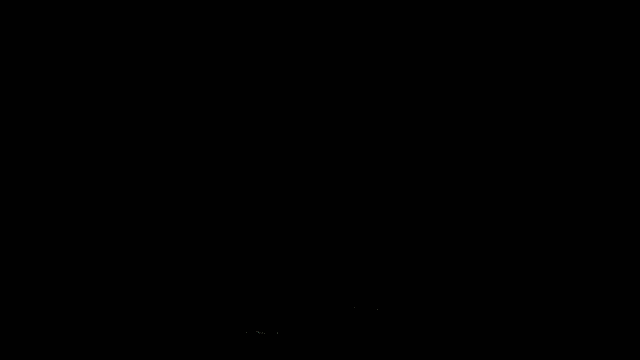

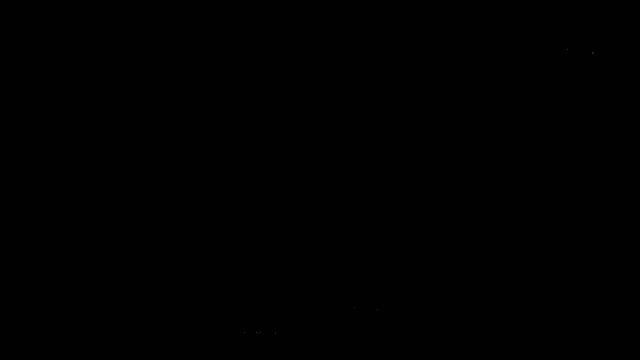

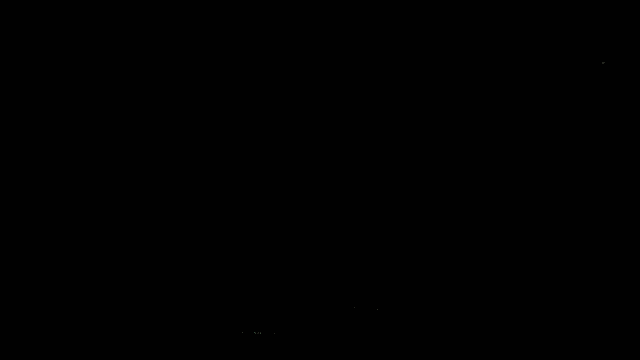

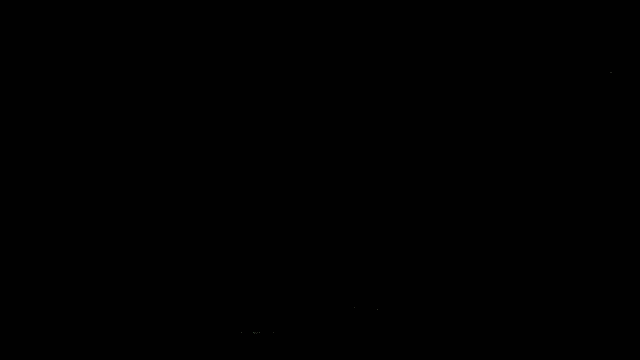

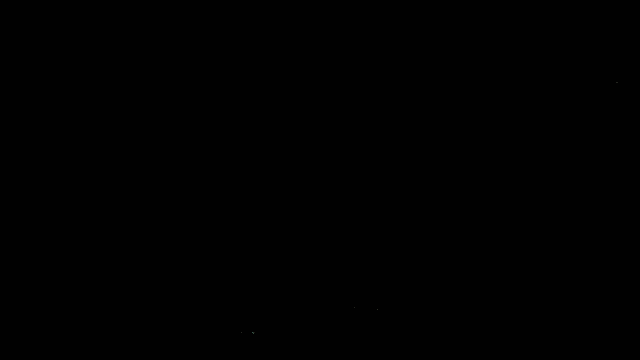

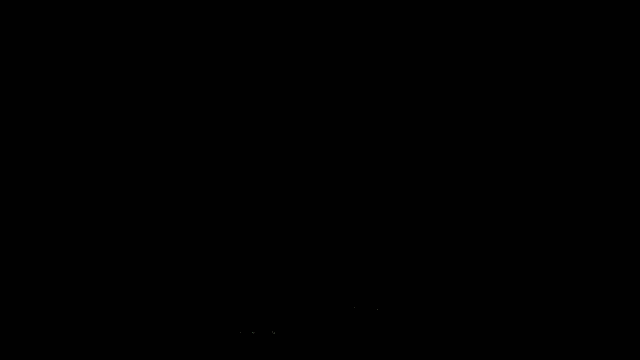

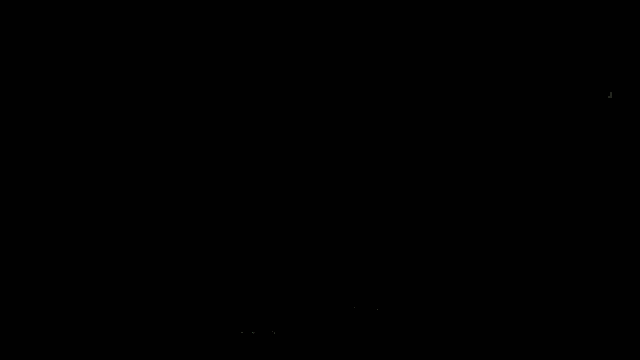

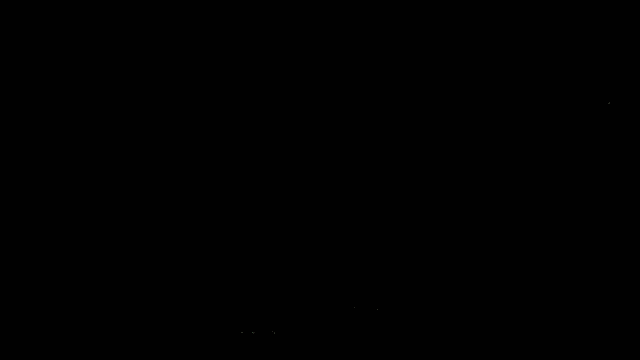

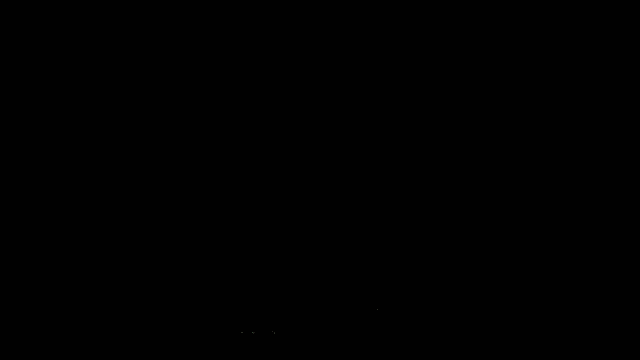

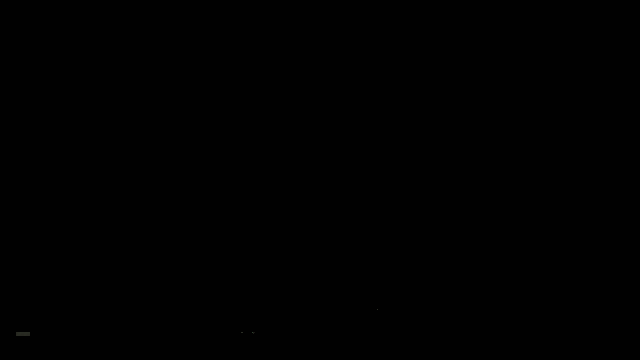

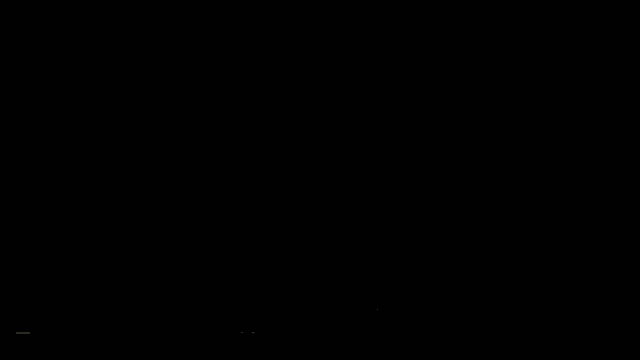

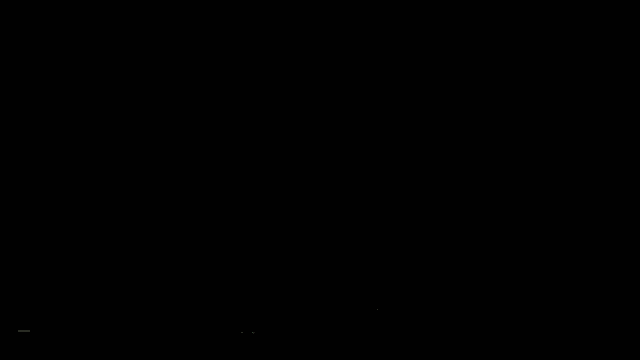

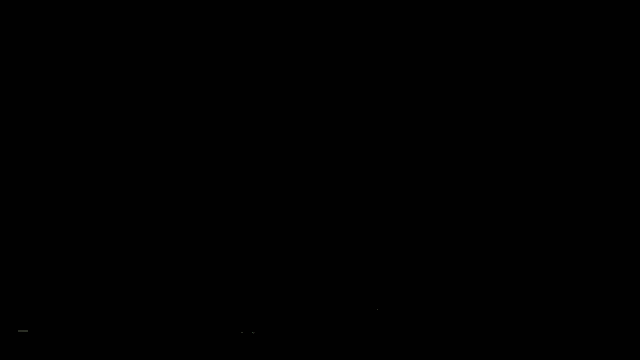

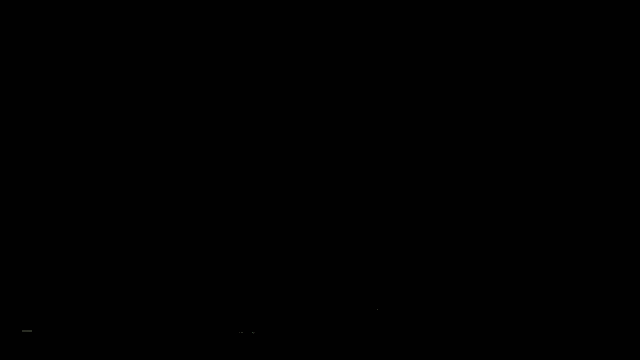

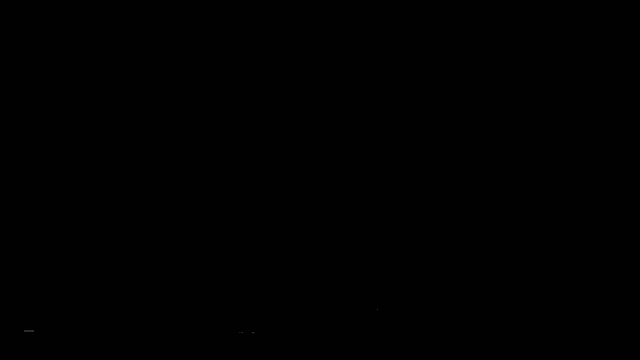

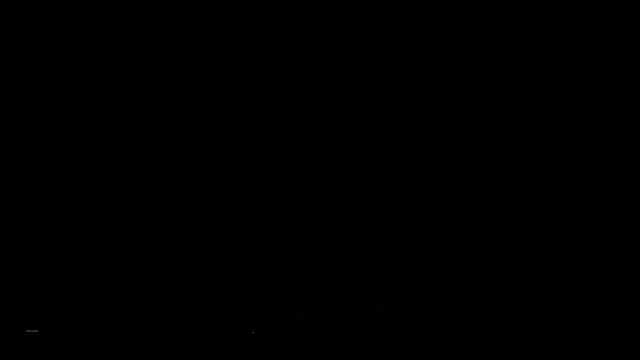

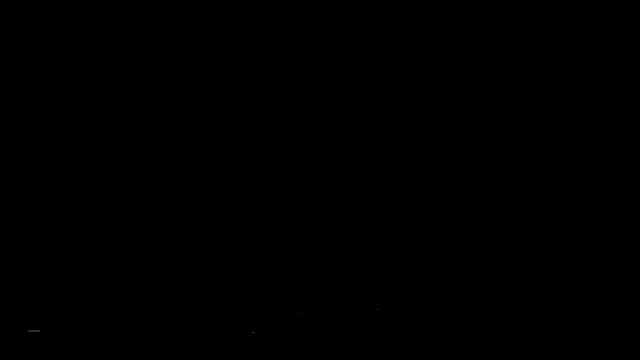

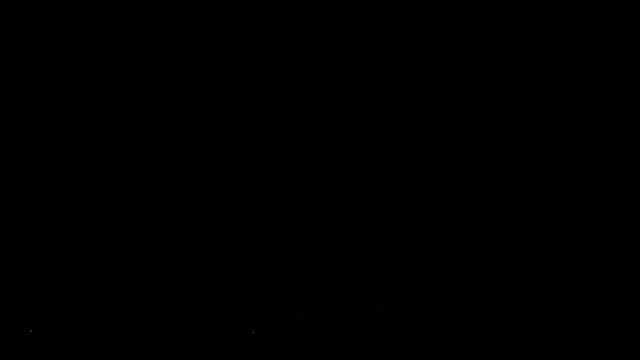

KeyboardInterrupt: ignored

In [14]:
# import cv2
# vs = cv2.VideoCapture("/content/sport2.mp4")
# totalFrames = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))

# grabbed = True
# currentFrame = 0
# start = time.time()
# writer = None

# output_fname = "/content/drive/My Drive/Colab Notebooks/manutd_and_chelsea_detected.mpg"
# # Configure the video writer
# width = int(vs.get(cv2.CAP_PROP_FRAME_WIDTH))
# height = int(vs.get(cv2.CAP_PROP_FRAME_HEIGHT))
# frames_per_second = vs.get(cv2.CAP_PROP_FPS)
# num_frames = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
# outvideo = cv2.VideoWriter(
#                 filename=output_fname,
#                 # some installation of opencv may not support x264 (due to its license),
#                 # you can try other format (e.g. MPEG)
#                 fourcc=cv2.VideoWriter_fourcc(*"MPEG"),
#                 fps=float(frames_per_second),
#                 frameSize=(width, height),
#                 isColor=True,
#             )


# # loop over frames from the video file stream (207)
# while grabbed:
#   (grabbed, frame) = vs.read()
#   hsv = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
#   lower_range = np.array([40, 40, 40])                         # Set the Lower range value of green in BGR
#   upper_range = np.array([70, 255, 255])
#   mask = cv2.inRange(hsv, lower_range, upper_range)     # Create a mask with range
#   result = cv2.bitwise_and(frame, frame, mask = mask)
#   res_bgr = cv2.cvtColor(result,cv2.COLOR_HSV2BGR)
#   res_gray = cv2.cvtColor(result,cv2.COLOR_BGR2GRAY)
  
  
#   #Defining a kernel to do morphological operation in threshold #image to get better output.
#   kernel = np.ones((13,13),np.uint8)
#   thresh = cv2.threshold(res_gray,127,255,cv2.THRESH_BINARY_INV |  cv2.THRESH_OTSU)[1]
#   thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel) 
#   contours,hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#   idx = 0

#   for c in contours:
#     x, y, w, h = cv2.boundingRect(c)
#     idx = idx + 1

#     player_img = frame[y:y + h, x:x + w]
#     player_hsv = cv2.cvtColor(player_img, cv2.COLOR_BGR2HSV)
#     mask1 = cv2.inRange(player_hsv, lower_range, upper_range)
#     res1 = cv2.bitwise_and(player_img, player_img, mask=mask1)
#     res1_bgr = cv2.cvtColor(res1,cv2.COLOR_HSV2BGR)
#     res1_gray = cv2.cvtColor(res1,cv2.COLOR_BGR2GRAY)
#     # cv2_imshow(res1_gray)

#     outputs = predictor(res1_bgr)   

#     v = VideoVisualizer(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
#     v = v.draw_instance_predictions(res1_bgr,outputs["instances"].to("cpu"))
#     cv2_imshow(v.get_image() + idx)
#     # cv2_imshow(result)
#     outvideo.write(v.get_image())
#     if cv2.waitKey(1) == 27:
#       break  # esc to quit
# vs.release()
    
#     # print(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
#     # if cfg.DATASETS.TRAIN[thing_classes[0]] == "person":
#     #    cfg.DATASETS.TRAIN[thing_classes[0] == "player"
#     # cv2_imshow(frame)
#   # cv2_imshow(frame) 




In [0]:
# import numpy as np
# import cv2

# vs = cv2.VideoCapture("/content/soccer.mp4")
# output_fname = "/content/drive/My Drive/Colab Notebooks/manutd_and_chelsea_detected.mpg"
# # Configure the video writer
# width = int(vs.get(cv2.CAP_PROP_FRAME_WIDTH))
# height = int(vs.get(cv2.CAP_PROP_FRAME_HEIGHT))
# frames_per_second = vs.get(cv2.CAP_PROP_FPS)
# num_frames = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
# outvideo = cv2.VideoWriter(
#                 filename=output_fname,
#                 # some installation of opencv may not support x264 (due to its license),
#                 # you can try other format (e.g. MPEG)
#                 fourcc=cv2.VideoWriter_fourcc(*"MPEG"),
#                 fps=float(frames_per_second),
#                 frameSize=(width, height),
#                 isColor=True,
#             )
# fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows=False)

# # loop over frames from the video file stream (207)
# while vs.isOpened():
#     ret, frame = vs.read()

#     fgmask = fgbg.apply(frame)
#     # fgmask = cv2.cvtColor(fgmask,cv2.COLOR_GRAY2BGR)
#     outputs = predictor(frame)  
#     # instances = outputs["instances"].to("cpu")
#     # boxes = instances.get("pred_boxes")
#     # scale=0.8,instance_mode=ColorMode.IMAGE_BW 

#     v = Visualizer(frame[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),scale=1.2)
#     v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#     cv2_imshow(v.get_image()[:, :, ::-1])
 
#     # cv2_imshow('fgmask',frame)
#     # cv2_imshow(fgmask)

    
#     k = cv2.waitKey(30) & 0xff
#     if k == 27:
#         break
    

# cap.release()
# cv2.destroyAllWindows()

In [0]:
# # Run frame-by-frame inference demo on this video (takes 3-4 minutes)
# # Using a model trained on COCO dataset
# #This part is just a manual process
# !cd /content/detectron2_repo && python3 /content/detectron2_repo/demo/demo.py --config-file configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input /content/manutd_and_chelsea.mp4 --confidence-threshold 0.9 --output /content/detectron2_repo/manutd_and_chelsea_detected.mpg --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

In [0]:
# cap = cv2.VideoCapture("/content/soccer.mp4")
#     # Configure the video writer

# # The size of frame must be the same that the output image predicted
# frame_width = int(cap.get(3))
# frame_height =int(cap.get(4))
# video_writer = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), cap.get(cv2.CAP_PROP_FPS), 
#                                 (frame_width, frame_height))
# while True:
#     ret, image = cap.read()
    
#     outputs = predictor(image)

#     v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
#     v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#     img = arrayShow(v.get_image()[:, :, ::-1])
#     display(img)
#     output_video = "/content/drive/My Drive/Colab Notebooks/Socccer Activity Identification/detectron_video1.avi"
#     if writer is None:
#       fourcc = cv2.VideoWriter_fourcc(*"MJPG")
# 		  writer = cv2.VideoWriter(ou, fourcc, 30,(W, H), True)
# 	  writer.write(output_video)

In [0]:
# # Test one video
# video_path = "/content/drive/My Drive/Colab Notebooks/jersey/manutd_and_chelsea.mp4"
# # Open the video
# video_cap = cv2.VideoCapture(video_path)

# # Configure the video writer

# # The size of frame must be the same that the output image predicted
# frame_width =int(video_cap.get(3))#640
# print(frame_width)
# frame_height =int(video_cap.get(4))#360
# print(frame_height)

# # writing the output to a video
# video_writer = cv2.VideoWriter('output.mp4', 
#                                 cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
#                                 video_cap.get(cv2.CAP_PROP_FPS), 
#                                 (frame_width, frame_height))

# if video_cap.isOpened() == False:
#     print(f"Error opening the video: {video_path}")

# # Read all video frames
# while(video_cap.isOpened()):
#     success, image = video_cap.read()
#     #print(f"Original shape: {image.shape}")  
#     # Make predictions
#     outputs = predictor(image)

#     v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)

#     # print((outputs['instances'].pred_classes).detach())
#     # print((outputs['instances'].scores).detach())

#     v = v.draw_instance_predictions(outputs['instances'].to("cpu"))

#     # Write the frame
#     img = v.get_image()[:, :, ::-1]
#     print(f"Output shape: {img.shape}")
#     video_writer.write(img)


# # Release the video capture and writer
# video_cap.release()
# video_writer.release()


# # Test one image
# # image_path = os.path.join("input", "sample.jpg")
# # test_image(image_path)




In [0]:
# from google.colab.patches import cv2_imshow
# cap = cv2.VideoCapture("/content/soccer.mp4")
# # Configure the video writer

# # The size of frame must be the same that the output image predicted
# frame_width =int(video_cap.get(3))#640
# print(frame_width)
# frame_height =int(video_cap.get(4))#360
# print(frame_height)

# # writing the output to a video
# video_writer = cv2.VideoWriter('output1.mp4', 
#                                 cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
#                                 video_cap.get(cv2.CAP_PROP_FPS), 
#                                 (frame_width, frame_height))
# while True:
#     ret, image = cap.read()
    
#     outputs = predictor(image)

#     v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
#     v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#     img = arrayShow(v.get_image()[:, :, ::-1])
#     # cv2_imshow(v.get_image()[:, :, ::-1])
#     # Write the frame
#     img = v.get_image()[:, :, ::-1]
#     # print(f"Output shape: {img.shape}")
#     video_writer.write(img)

#     # display(img)
    

In [0]:
# import os
# import cv2

# from detectron2.engine import DefaultPredictor
# from detectron2.utils.visualizer import Visualizer

# from detectron2.config import get_cfg
# from detectron2 import model_zoo

# from detectron2.data import MetadataCatalog
# from detectron2.utils.visualizer import ColorMode

# def visualize_predictions(frame, metadata, preds):
#     v = Visualizer(frame[:, :, ::-1],
#                    metadata=metadata,
#                    scale=1,
#                    instance_mode=ColorMode.IMAGE
#                    )
#     v = v.draw_instance_predictions(preds["instances"].to("cpu"))
#     return v.get_image()[:, :, ::-1]

# if __name__ == "__main__":
#     models_pretrained_list = [
#         "faster_rcnn_R_50_FPN_3x_700_box.pth",
#         "detectron2://COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl",
#         "mask_rcnn_R_50_FPN_3x_700_box.pth"
#     ]
#     models_pretrained_type_list = [
#         "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",
#         "/content/detectron2_repo/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml",
#         "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
#     ]
#     model_path = models_pretrained_list[2]
#     MetadataCatalog.get("metadata_classes").set(thing_classes=["box"])

#     cfg = get_cfg()
#     cfg.merge_from_file(model_zoo.get_config_file(models_pretrained_type_list[2]))
#     cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

#     cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, model_path)
#     cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.80

#     predictor = DefaultPredictor(cfg)
#     metadata_classes = MetadataCatalog.get("metadata_classes")

#     cap = cv2.VideoCapture("/content/drive/My Drive/Colab Notebooks/jersey/manutd_and_chelsea.mp4")

#     frame_width = int(cap.get(3))
#     frame_height = int(cap.get(4))
#     out = cv2.VideoWriter('result/rezult.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 25, (frame_width, frame_height))

#     frame_det = 2
#     ret, frame = cap.read()
#     preds = predictor(frame)
#     del ret, frame

#     while cap.isOpened():
#         ret, frame = cap.read()

#         if (frame_det == 2):
#             preds = predictor(frame)
#             frame_det = 0
#         frame_det += 1

#         image = visualize_predictions(frame, metadata_classes, preds)
#         out.write(image)
#         cv2.imshow('frame', image)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
#     cap.release()
#     cv2.destroyAllWindows()

In [0]:
# from google.colab.patches import cv2_imshow
# cap = cv2.VideoCapture("/content/soccer.mp4")
# # Configure the video writer

# while True:
#     ret, image = cap.read()
    
#     outputs = predictor(image)

#     v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
#     v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#     img = arrayShow(v.get_image()[:, :, ::-1])
#     cv2_imshow(v.get_image()[:, :, ::-1])
#     # display(img)
    